In [246]:
import numpy as np
import pandas as pd
import os
print(os.listdir(".\input"))

['usps.h5']


In [247]:
import h5py 
from functools import reduce

def getUspDataSet(path):
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        x_Train = train.get("data")[:]
        y_Train = train.get("target")[:]
        test = hf.get('test')
        x_Test = test.get("data")[:]
        y_Test = test.get("target")[:]
    return x_Train, y_Train, x_Test, y_Test

In [248]:
import matplotlib.pyplot as plt

def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary')
    plt.show()

In [249]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images,labels,
                                  prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images.iloc[idx, np.arange(0, 256)].as_matrix().reshape([16, 16]), cmap='binary')
        title= "label=" +str(labels.iloc[idx,0])
        if len(prediction)>0:
            title+=",predict="+str(prediction.iloc[idx,0]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

In [250]:
# 2-norm

def norm2 (a, ak):
    return np.linalg.norm(a-ak, 2)

In [251]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [252]:
x_Train_data = pd.concat([pd.DataFrame(x_Train),pd.DataFrame(y_Train, columns=['digital'])], axis=1)
x_Test_data = pd.concat([pd.DataFrame(x_Test),pd.DataFrame(y_Test, columns=['digital'])], axis=1)

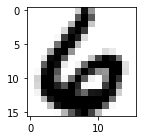

In [253]:
plot_image(x_Train_data.iloc[0, np.arange(0, 256)].as_matrix().reshape([16, 16]))

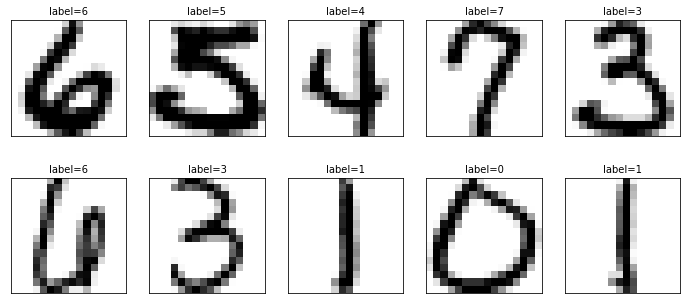

In [254]:
plot_images_labels_prediction(x_Train_data.loc[:,np.arange(0, 256)], x_Train_data.loc[:,['digital']],[],0,)

In [255]:
feature_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Total'])

table = np.zeros((2, 11))

for i in range(11):
    table[0][i] = x_Train_data[x_Train_data['digital'] == i].shape[0]
    table[1][i] = x_Test_data[x_Test_data['digital'] == i].shape[0]
    if i == 10:
        table[0][i] = x_Train_data.shape[0]
        table[1][i] = x_Test_data.shape[0]

pd.DataFrame(table, columns=feature_names)

,0,1,2,3,4,5,6,7,8,9,Total
0,1194.0,1005.0,731.0,658.0,652.0,556.0,664.0,645.0,542.0,644.0,7291.0
1,359.0,264.0,198.0,166.0,200.0,160.0,170.0,147.0,166.0,177.0,2007.0


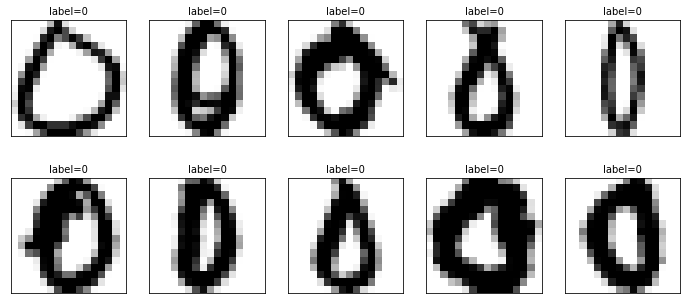

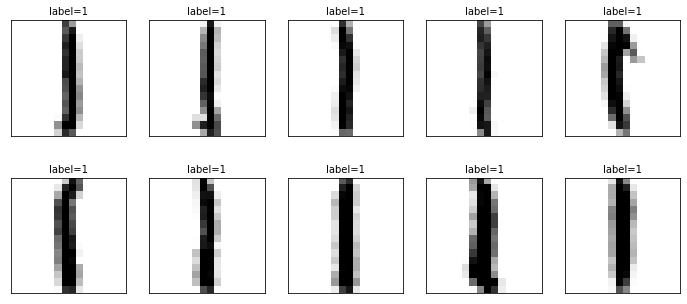

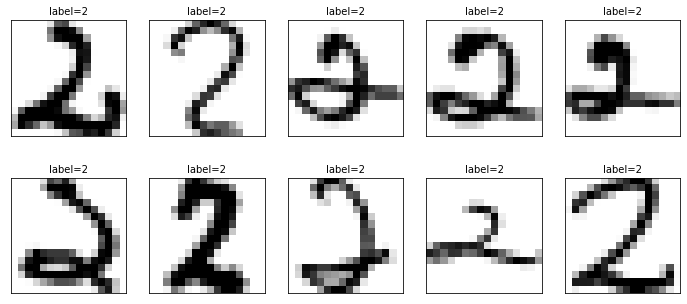

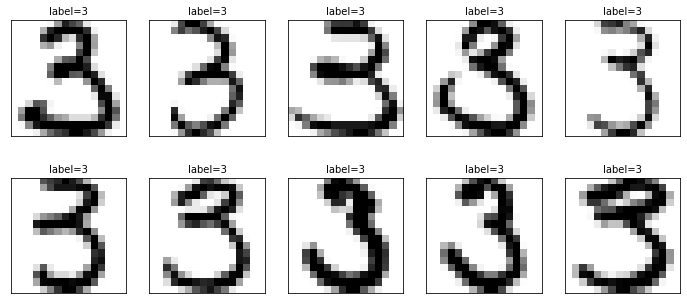

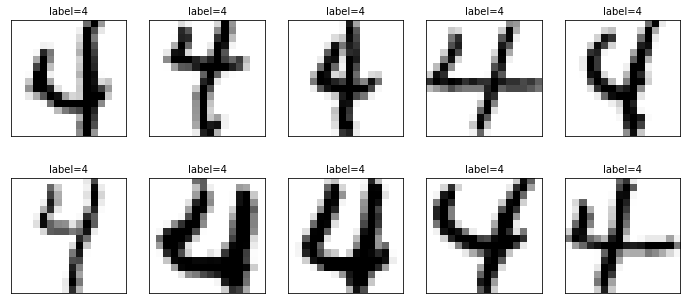

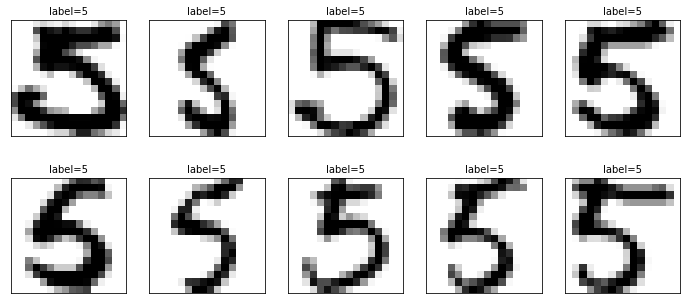

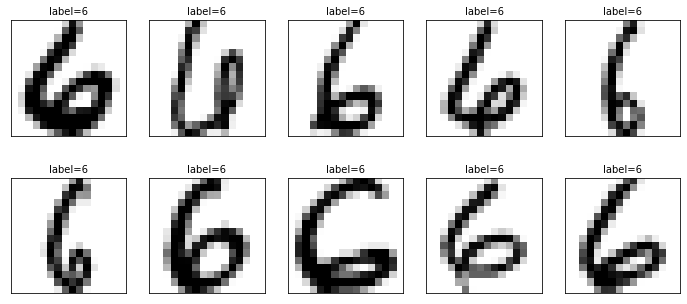

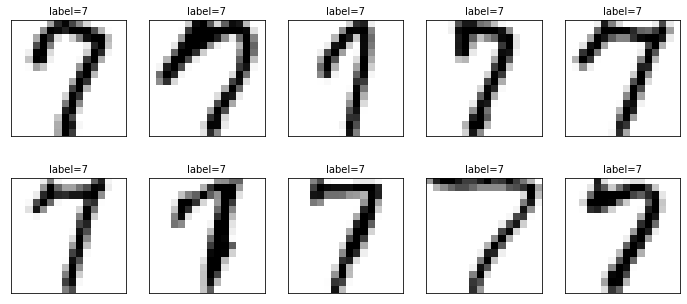

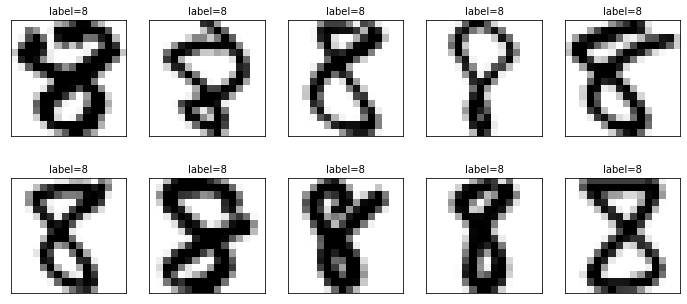

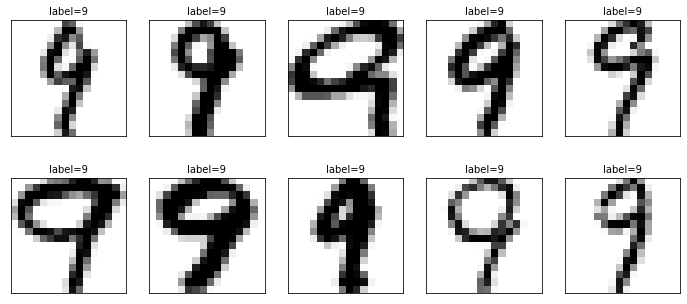

In [256]:
for i in range(0,10):
    plot_images_labels_prediction(x_Train_data[x_Train_data['digital'] == i].loc[:,np.arange(0, 256)], x_Train_data[x_Train_data['digital'] == i].loc[:,['digital']],[],0,)

# Handwritten Digits and a Simple Algorithm

### 透過 training set 取得手寫數字0~9的平均值陣列
### 將 testing set 每一張手寫數字與0~9平均值陣列比對，取最小的2norm，預測該張手寫數字代表的數字

In [257]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [258]:
def getMeanDigitalTable(x_Data, y_Data):

    x_Date_list = pd.concat([pd.DataFrame(x_Data),pd.DataFrame(y_Data, columns=['digital'])], axis=1)
    meanDigitalTable = np.zeros((10, 257))

    for i in range(10):
        for j in range(257):       
            if j == 256:
                meanDigitalTable[i][j] = int(i)
            else:
                meanDigitalTable[i][j] = x_Date_list[x_Date_list['digital'] == i].loc[:,np.arange(0, 256)].mean(axis = 0)[j]

    x_Train_mean = pd.DataFrame(meanDigitalTable, columns=np.arange(0, 257))

    return x_Train_mean

In [259]:
x_Train_mean = getMeanDigitalTable(x_Train, y_Train)

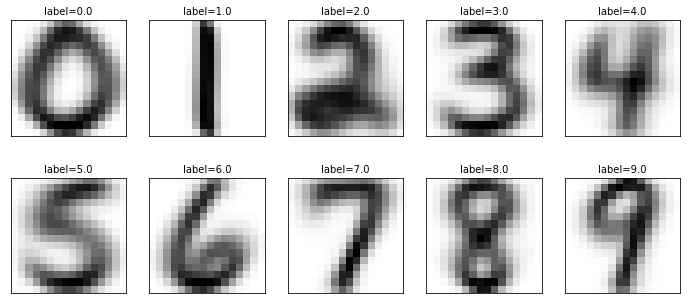

In [260]:
plot_images_labels_prediction(x_Train_mean.loc[:,np.arange(0, 256)], x_Train_mean.loc[:,[256]],[],0,10)

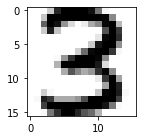

In [261]:
plot_image(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

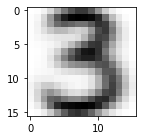

In [262]:
plot_image(x_Train_mean.iloc[3, np.arange(0, 256)].as_matrix().reshape([16, 16]))

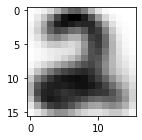

In [263]:
plot_image(x_Train_mean.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

In [264]:
norm2(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]), x_Train_mean.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

5.097931406215535

In [265]:
def simpleAlgorithm(x_Test_data, x_Train_mean):

    total = x_Test_data.shape[0]
    isSuccess = 0
    isError = 0
    normList = np.zeros((1, 10))
    result = np.zeros((total, 1))
    result_residual = np.zeros(total)

    for i in range(0, total):

        for j in range(0,10):
            residual_list = np.ones((10))

            normValue = norm2(x_Test_data.iloc[i, np.arange(0, 256)].as_matrix().reshape([16, 16]), x_Train_mean.iloc[j, np.arange(0, 256)].as_matrix().reshape([16, 16]))
            normList[0][j] = normValue

        prediction = np.where(normList == np.amin(normList))

        result[i][0] = int(prediction[1])
        
        result_residual[i] = np.amin(normList)

    tempPd = pd.concat([x_Test_data, pd.DataFrame(result, columns=['prediction'])], axis=1)
    x_Test_Prediction = pd.concat([tempPd, pd.DataFrame(result_residual, columns=['residual'])], axis=1)
    
    x_Test_result = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].shape[0]/x_Test_Prediction.shape[0]

    return x_Test_Prediction, x_Test_result

In [266]:
x_Test_Prediction, x_Test_result = simpleAlgorithm(x_Test_data, x_Train_mean)

In [267]:
x_Test_Prediction[x_Test_Prediction['prediction'] != x_Test_Prediction['digital']]

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,digital,prediction,residual
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0,6,2.0,3.818170
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0,6,2.0,4.163254
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0710,0.4470,0.9010,...,0.6450,0.3155,0.0665,0.0000,0.0000,0.000,0.0,6,0.0,3.949304
12,0.0000,0.0000,0.7345,0.7065,1.0000,1.0000,0.7310,0.4420,0.0315,0.0000,...,0.6350,0.3600,0.0725,0.0000,0.0000,0.000,0.0,2,3.0,3.343624
15,0.0000,0.0000,0.0000,0.6320,0.7660,0.3950,0.1270,0.1105,0.0000,0.0000,...,0.0855,0.0000,0.0000,0.0000,0.0000,0.000,0.0,3,9.0,3.158675
17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0565,0.6955,0.2200,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0,6,2.0,3.703112
23,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2795,0.7650,1.0000,...,0.4715,0.7790,0.0005,0.0000,0.0000,0.000,0.0,9,4.0,2.873120
27,0.0000,0.0000,0.0085,0.8310,0.2455,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.7565,0.5045,0.1985,0.0000,0.0000,0.000,0.0,3,5.0,3.262365
28,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5160,0.6390,...,0.9360,0.6765,0.2860,0.0075,0.0000,0.000,0.0,8,5.0,3.324758
36,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0,5,4.0,4.352309


In [268]:
print("準確率為 :", x_Test_result)

準確率為 : 0.7767812655705032


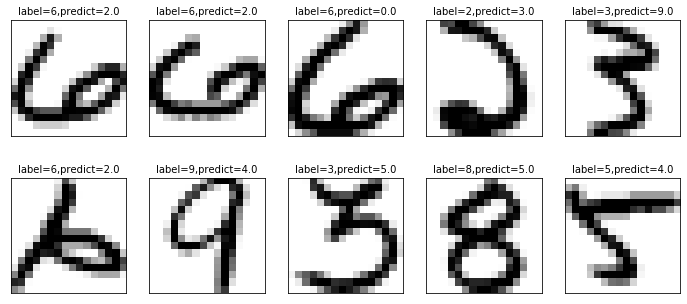

In [269]:
errorList = x_Test_Prediction[x_Test_Prediction['digital'] != x_Test_Prediction['prediction']]

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [270]:
temp = errorList[['digital', 'prediction']].groupby(['digital', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

,0,1,2,3,4,5,6,7,8,9
0,6.0,6.0,4.0,5.0,9.0,3.0,0.0,9.0,5.0,4.0
1,35.0,3.0,16.0,21.0,31.0,17.0,10.0,13.0,15.0,15.0
2,5.0,9.0,3.0,0.0,2.0,0.0,5.0,4.0,2.0,8.0
3,8.0,3.0,13.0,9.0,9.0,12.0,9.0,6.0,9.0,8.0


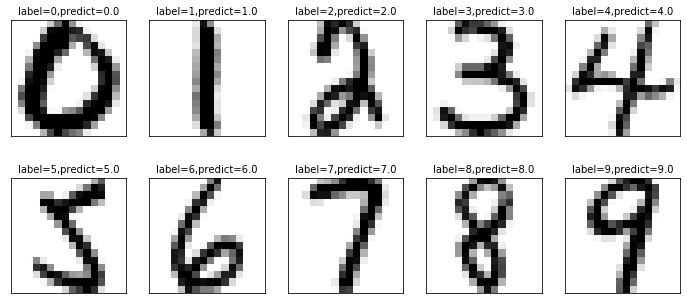

In [271]:
minList = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].groupby('digital').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = x_Test_Prediction[x_Test_Prediction['digital'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = x_Test_Prediction.iloc[x_Test_Prediction.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

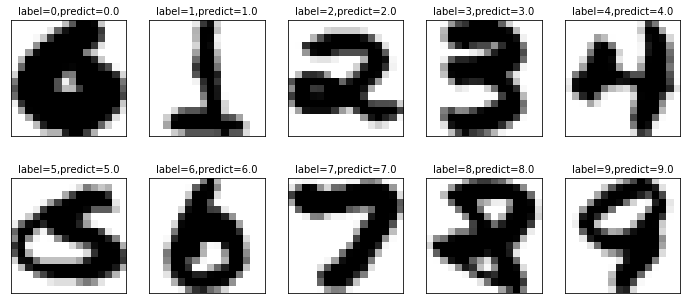

In [272]:
maxList = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].groupby('digital').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = x_Test_Prediction[x_Test_Prediction['digital'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = x_Test_Prediction.iloc[x_Test_Prediction.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [498]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [499]:
x_Teacher_data = pd.concat([pd.DataFrame(x_Teacher),pd.DataFrame(y_Teacher, columns=['digital'])], axis=1)

In [500]:
x_Teacher_Prediction, x_Teacher_result = simpleAlgorithm(x_Teacher_data, x_Train_mean)
x_Teacher_result

0.3

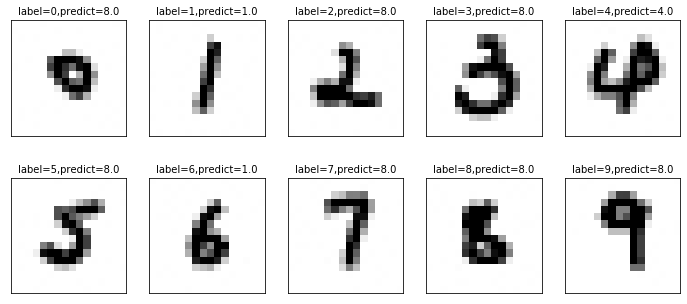

In [501]:
plot_images_labels_prediction(x_Teacher_Prediction.iloc[:,np.arange(0, 256)], x_Teacher_Prediction.iloc[:,[256]], x_Teacher_Prediction.iloc[:,[257]],0,10)

In [502]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [503]:
x_Teacher_data = pd.concat([pd.DataFrame(x_Teacher),pd.DataFrame(y_Teacher, columns=['digital'])], axis=1)

In [504]:
x_Teacher_Prediction, x_Teacher_result = simpleAlgorithm(x_Teacher_data, x_Train_mean)
x_Teacher_result

0.4

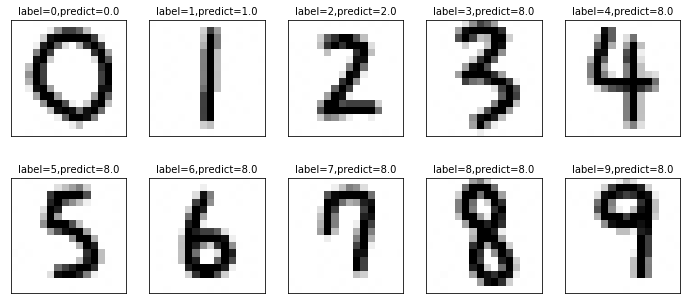

In [505]:
plot_images_labels_prediction(x_Teacher_Prediction.iloc[:,np.arange(0, 256)], x_Teacher_Prediction.iloc[:,[256]], x_Teacher_Prediction.iloc[:,[257]],0,10)

# Classification Using SVD Bases

In [276]:
def getUList(x_Data, y_Data):
    # We now normalize all values between 0 and 1 and we now flatten the 16 × 16 images into vectors of size 256.

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))
    x_Data = x_Data.T
    
    #  we now partition the x_train based on the ten classes and store in a list.

    x_list = []

    for k in range(10):
        components = np.where(y_Data == k)[0]
        x_list.append(x_Data[:, components])

    # we now create a svd basis for each digit data samples.

    U_list = []

    for k in range(10):
        U, S, V = np.linalg.svd(x_list[k])
        U_list.append(U)
    
    return U_list


def svdAlgorithm (x_Data, y_Data, U_list,basis):
    # We now normalize all values between 0 and 1 and we now flatten the 16 × 16 images into vectors of size 256.

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))
    x_Data = x_Data.T

    # we now select the dominant orthogonal basis and project the digits on the reduced basis to compute the least square projection error.

    result_mse = []
    result_residual = []

    for r in range(basis):
        n_Data = x_Data.shape[1]
        y_predict = np.ones(n_Data)
        result_single = np.ones(n_Data)

        for i in range(0, n_Data):
            z = x_Data[:, i]
            residual_list = np.ones(10)
            
            for j in range(10):
                U_k = U_list[j][:, :r+1]
                residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
                residual_list[j] = residual

            y_predict[i] = np.argmin(residual_list)
            
            if r == basis-1:
                result_residual.append(residual_list)
                result_single[i] = np.amin(residual_list)

        result_mse.append(np.mean((y_Data/1.0 - y_predict/1.0) ** 2))
    
    x_Data_list = pd.concat([pd.DataFrame(x_Data.T),pd.DataFrame(y_Data, columns=['actual'])], axis=1)
    result_List = pd.concat([x_Data_list, pd.DataFrame(y_predict, columns=['prediction'])], axis=1)
    result_List = pd.concat([result_List, pd.DataFrame(result_single, columns=['residual'])], axis=1)

    result_predict = result_List[result_List['actual'] == result_List['prediction']].shape[0]/result_List.shape[0]

    return result_List, y_predict, result_predict, result_residual, result_mse

In [277]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [512]:
U_list = getUList(x_Train, y_Train)

In [279]:
result_Train_list, y_Train_predict, result_Train_predict, result_Train_residual, result_Train_mse = svdAlgorithm(x_Train, y_Train, U_list, 10)

In [280]:
result_Train_predict

0.9680427924838843

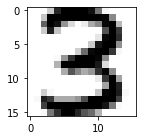

In [281]:
plot_image(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))
z = x_Test_data.iloc[2, np.arange(0, 256)]

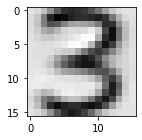

0.2509679228624524

In [282]:
U_k = U_list[3][:, :10+1]
plot_image(np.dot(U_k, np.dot(U_k.T, z)).reshape([16, 16]))
residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
residual

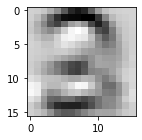

0.49734799699082527

In [283]:
U_k = U_list[2][:, :10+1]
plot_image(np.dot(U_k, np.dot(U_k.T, z)).reshape([16, 16]))
residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
residual

In [284]:
result_Train_list[result_Train_list['prediction'] != result_Train_list['actual']]

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,actual,prediction,residual
14,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000722,0.003200,...,0.001959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,9.0,0.393277
21,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000024,0.003227,0.003445,0.001529,...,0.003922,0.001167,0.000000,0.000000,0.000000,0.000000,0.000000,8,7.0,0.562194
38,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002233,0.002504,0.000000,0.000000,...,0.000000,0.000753,0.003231,0.002947,0.001275,0.000000,0.000000,4,0.0,0.483822
52,0.0,0.000000,0.000000,0.000000,0.000000,0.000710,0.002396,0.003345,0.003922,0.003394,...,0.003037,0.002496,0.002106,0.001798,0.000000,0.000000,0.000000,2,7.0,0.599187
53,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.001333,0.003394,0.000673,0.000000,...,0.000467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1.0,0.475028
81,0.0,0.000000,0.001816,0.002984,0.002984,0.002984,0.002984,0.002984,0.002984,0.002984,...,0.002882,0.001645,0.000394,0.000000,0.000000,0.000000,0.000000,8,3.0,0.477675
196,0.0,0.000000,0.000000,0.000000,0.000000,0.000661,0.003600,0.001135,0.000606,0.000969,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,9.0,0.526537
209,0.0,0.000000,0.000000,0.000000,0.000000,0.001088,0.002341,0.003824,0.003320,0.000663,...,0.002076,0.002076,0.000437,0.000000,0.000000,0.000000,0.000000,2,8.0,0.610668
212,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000076,0.002967,...,0.002620,0.000786,0.000000,0.000000,0.000000,0.000000,0.000000,4,1.0,0.501959
226,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,7.0,0.505268


In [285]:
result_Train_residual[7290]

array([0.62684596, 0.1769527 , 0.55635041, 0.63328332, 0.39543733,
       0.61783707, 0.55588669, 0.56893593, 0.35287929, 0.48034778])

In [286]:
result_Train_mse

[3.198052393361679,
 1.4978740913454944,
 1.2891235770127554,
 0.9462350843505692,
 0.7939925936085585,
 0.7944040597997531,
 0.7104649567960499,
 0.5841448360993005,
 0.5739953367164998,
 0.5336716499794267]

Text(0.5, 0, 'number of basis')

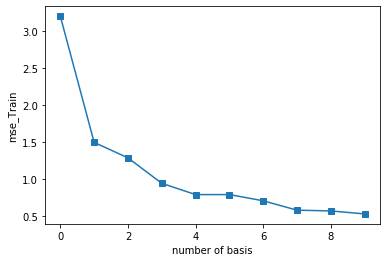

In [287]:
plt.plot(result_Train_mse,'s-')
plt.ylabel('mse_Train')
plt.xlabel('number of basis')

In [288]:
result_Test_list, y_Test_predict, result_Test_predict, result_Test_residual, result_Test_mse = svdAlgorithm(x_Test, y_Test, U_list, 20)

In [289]:
result_Test_predict

0.9412057797708022

In [290]:
result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']]

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,actual,prediction,residual
27,0.000000,0.000000,0.000033,0.003259,0.000963,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002967,0.001978,0.000778,0.000000,0.000000,0.000000,0.000000,3,5.0,0.435273
87,0.000000,0.000000,0.000000,0.000000,0.000994,0.003037,0.003922,0.001973,0.000335,0.000337,...,0.000941,0.000192,0.000000,0.000000,0.000000,0.000000,0.000000,8,2.0,0.468996
93,0.000000,0.002349,0.002600,0.000000,0.000000,0.002627,0.003922,0.001259,0.000000,0.000000,...,0.003733,0.001759,0.000000,0.000000,0.000000,0.000000,0.000000,8,5.0,0.560259
109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000029,0.002810,0.000410,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,9.0,0.464895
122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,7.0,0.638054
130,0.000000,0.000000,0.000000,0.000000,0.000104,0.001125,0.002688,0.003720,0.003922,0.003922,...,0.003541,0.003124,0.002331,0.000320,0.000000,0.000000,0.000000,8,5.0,0.457249
131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,4.0,0.650535
135,0.000000,0.000000,0.000147,0.001986,0.002857,0.003241,0.003051,0.002420,0.000553,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,7.0,0.310290
160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000402,0.001361,0.002312,0.003500,0.003922,...,0.000000,0.000000,0.000027,0.000820,0.002549,0.003227,0.000000,2,0.0,0.551710
164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000973,0.002053,0.003163,0.003684,...,0.003718,0.001282,0.000000,0.000000,0.000000,0.000000,0.000000,0,9.0,0.397156


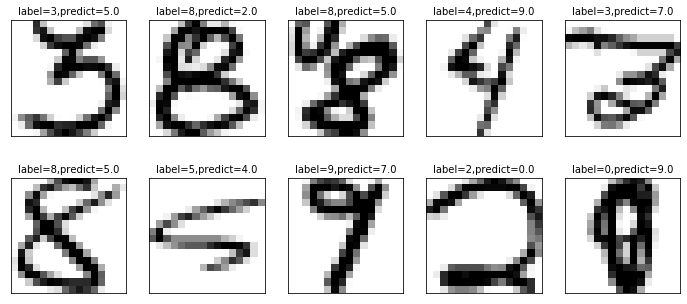

In [291]:
errorList = result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']]

errorList.shape

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [292]:
temp = errorList[['actual', 'prediction']].groupby(['actual', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

,0,1,2,3,4,5,6,7,8,9
0,1.0,4.0,0.0,5.0,9.0,0.0,5.0,4.0,3.0,4.0
1,2.0,3.0,8.0,13.0,5.0,5.0,4.0,3.0,4.0,4.0
2,2.0,6.0,4.0,2.0,1.0,8.0,4.0,1.0,0.0,1.0
3,2.0,2.0,5.0,3.0,3.0,3.0,1.0,1.0,3.0,2.0


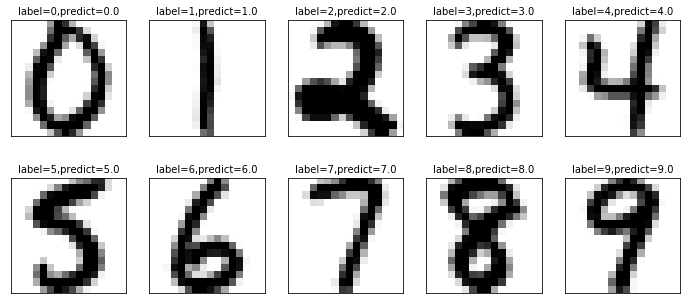

In [293]:
minList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = result_Test_list.iloc[result_Test_list.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

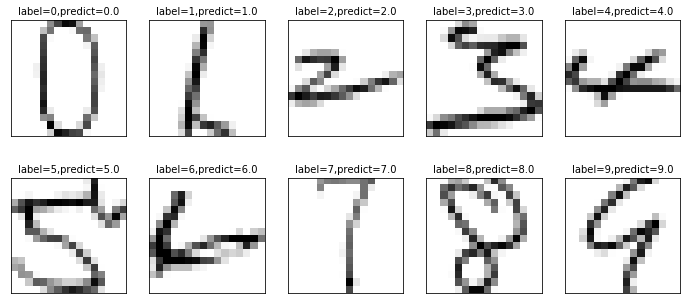

In [294]:
maxList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = result_Test_list.iloc[result_Test_list.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [295]:
result_Test_residual[2006]

array([0.66521549, 0.06187747, 0.65652156, 0.6250729 , 0.3532581 ,
       0.63854527, 0.42578962, 0.51065224, 0.45140523, 0.51292944])

In [296]:
result_Test_mse

[4.022421524663677,
 2.0269058295964126,
 1.8256103637269556,
 1.4867962132536123,
 1.2227204783258594,
 1.2825112107623318,
 1.1629297458893872,
 1.1031390134529149,
 1.0488290981564523,
 0.9725959142999502,
 0.9785749875435974,
 0.9237668161434978,
 0.9182859990034878,
 0.9157947184853015,
 0.9088191330343797,
 0.8629795714997509,
 0.9466865969108121,
 0.9387144992526159,
 0.9103139013452914,
 0.8809167912306926]

Text(0.5, 0, 'number of basis')

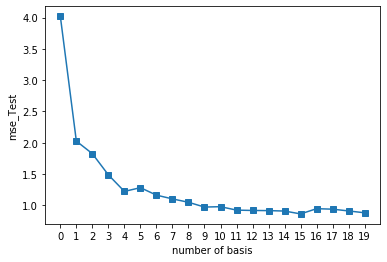

In [297]:
plt.plot(result_Test_mse,'s-')
plt.xticks(range(0,20))
plt.ylabel('mse_Test')
plt.xlabel('number of basis')

In [298]:
components = np.where(y_Test == 2)[0]
components
x_Test_2 = x_Test[components, :]
y_Test_2 = np.full(x_Test_2.shape[0],2)

In [299]:
result_Test_2_list, y_Test_2_predict, result_Test_2_predict, result_Test_2_residual, result_Test_2_mse = svdAlgorithm(x_Test_2, y_Test_2, U_list, 20)

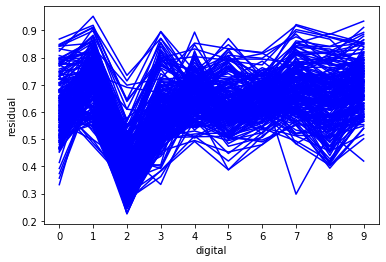

In [300]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_2.shape[0]):
    plt.plot(result_Test_2_residual[i],color = 'blue')

In [301]:
components = np.where(y_Test == 3)[0]
components
x_Test_3 = x_Test[components, :]
y_Test_3 = np.full(x_Test_3.shape[0],3)

In [302]:
result_Test_3_list, y_Test_3_predict, result_Test_3_predict, result_Test_3_residual, result_Test_3_mse = svdAlgorithm(x_Test_3, y_Test_3, U_list, 20)

In [303]:
result_Test_3_predict

0.8674698795180723

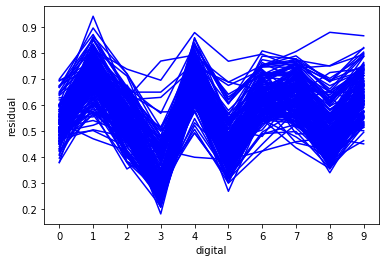

In [304]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_3.shape[0]):
    plt.plot(result_Test_3_residual[i],color = 'blue')

In [305]:
components = np.where(y_Test == 5)[0]
components
x_Test_5 = x_Test[components, :]
y_Test_5 = np.full(x_Test_5.shape[0],5)

In [306]:
result_Test_5_list, y_Test_5_predict, result_Test_5_predict, result_Test_5_residual, result_Test_5_mse = svdAlgorithm(x_Test_5, y_Test_5, U_list, 20)

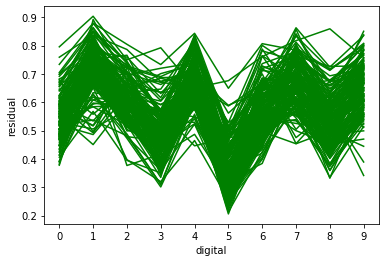

In [307]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_5.shape[0]):
    plt.plot(result_Test_5_residual[i],color = 'green')

In [308]:
components = np.where(y_Test == 7)[0]
components
x_Test_7 = x_Test[components, :]
y_Test_7 = np.full(x_Test_7.shape[0],7)

In [309]:
result_Test_7_list, y_Test_7_predict, result_Test_7_predict, result_Test_7_residual, result_Test_7_mse = svdAlgorithm(x_Test_7, y_Test_7, U_list, 10)

In [310]:
result_Test_7_predict

0.9455782312925171

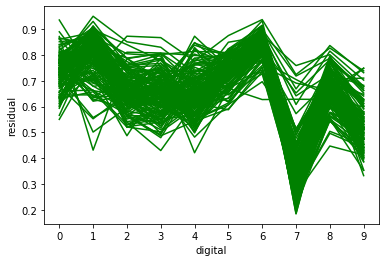

In [311]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_7.shape[0]):
    plt.plot(result_Test_7_residual[i], color = 'green')

In [513]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [514]:
result_Teacher_list, y_Teacher_predict, result_Teacher_predict, result_Teacher_residual, result_Teacher_mse = svdAlgorithm(x_Teacher, y_Teacher, U_list, 10)
result_Teacher_predict

0.5

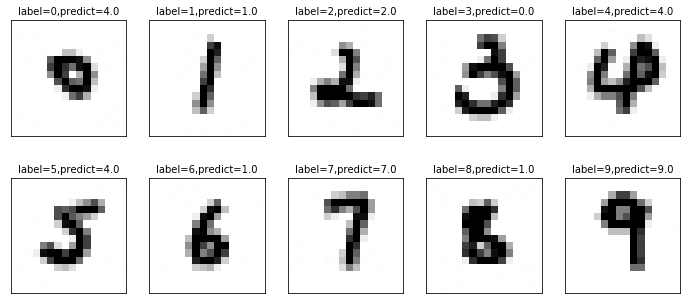

In [515]:
plot_images_labels_prediction(result_Teacher_list.iloc[:,np.arange(0, 256)], result_Teacher_list.iloc[:,[256]], result_Teacher_list.iloc[:,[257]],0,10)

In [516]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [517]:
result_Teacher_list, y_Teacher_predict, result_Teacher_predict, result_Teacher_residual, result_Teacher_mse = svdAlgorithm(x_Teacher, y_Teacher, U_list, 10)
result_Teacher_predict

0.9

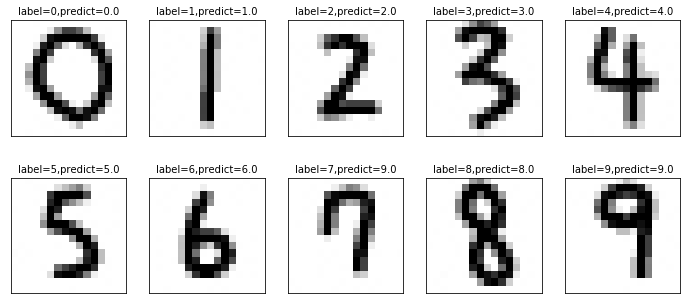

In [518]:
plot_images_labels_prediction(result_Teacher_list.iloc[:,np.arange(0, 256)], result_Teacher_list.iloc[:,[256]], result_Teacher_list.iloc[:,[257]],0,10)

# Classification Using higher order SVD (HOSVD)

In [320]:
import numpy as np
import torch as tc
import tensorly as tl
from tensorly.decomposition import tucker 

from sktensor import dtensor
from sktensor.tucker import hooi

def getSandUList(X_Date):
    X_Date = X_Date.astype('float32') / 255.
    X_Date = X_Date.reshape((len(X_Date), np.prod(X_Date.shape[1:])))

    x_list = []

    for k in range(10):
        components = np.where(y_Train == k)[0]
        x_list.append(x_Train[components, :])

    S_list = []
    U_list = []

    for k in range(10):

        tensor = np.zeros((16, 16, x_list[k].shape[0]))

        for i in range(x_list[k].shape[0]):
            tensor[:,:,i] = x_list[k][i][:].reshape([16, 16])

        A = dtensor(tensor)
        S, U = hooi(A, A.shape, init='nvecs')

        S_list.append(S)
        U_list.append(U)
    
    return S_list, U_list

def hosvdAlgorithm (x_Data, y_Data, S_list, U_list, basis):

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))

    result_mse = []
    result_residual = []

    for r in range(basis):
        n_Data = x_Data.shape[0]
        y_predict = np.ones((n_Data))
        result_single = np.ones(n_Data)

        for i in range(0, n_Data):
            Z = x_Data[i][:].reshape([16, 16])
            residual_list = np.ones((10))

            for d in range(10):
                U1, U2, U3 = U_list[d]
                S = S_list[d]
                
                Sigma = np.zeros((16, 16))

                for j in range(r+1):
                    Aj = U1.dot(S[:,:,j]).dot(U2.T)
                    Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
                    Sigma = Sigma + (Cj*Aj)

                G = np.linalg.norm(Z-Sigma, 2)

                residual_list[d] = G

            y_predict[i] = np.argmin(residual_list)

            if r == basis-1:
                result_residual.append(residual_list)
                result_single[i] = np.amin(residual_list)

        result_mse.append(np.mean((y_Data/1.0 - y_predict/1.0) ** 2))

    x_Data_list = pd.concat([pd.DataFrame(x_Data),pd.DataFrame(y_Data, columns=['actual'])], axis=1)
    result_list = pd.concat([x_Data_list, pd.DataFrame(y_predict, columns=['prediction'])], axis=1)
    result_list = pd.concat([result_list, pd.DataFrame(result_single, columns=['residual'])], axis=1)
    result_prediction = result_list[result_list['prediction'] == result_list['actual']].shape[0]/result_list.shape[0]

    return result_list, y_predict, result_prediction, result_residual, result_mse

In [321]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


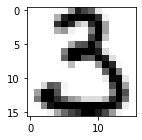

In [322]:
x_Train.shape
plot_image(x_Train[4][:].reshape([16, 16]))

In [323]:
components = np.where(y_Train == 3)[0]
components
x_Train_3 = x_Train[components, :]
y_Train_3 = np.full(x_Train_3.shape[0],3)

x_Train_3.shape

(658, 256)

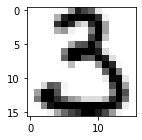

In [324]:
tensor = np.zeros((16, 16, x_Train_3.shape[0]))

for i in range(x_Train_3.shape[0]):
    tensor[:,:,i] = x_Train_3[i][:].reshape([16, 16])

plot_image(tensor[:,:,0])

In [325]:
A = dtensor(tensor)
S, U = hooi(A, A.shape, init='nvecs')

In [326]:
S.shape, U[0].shape, U[1].shape, U[2].shape

((16, 16, 658), (16, 16), (16, 16), (658, 658))

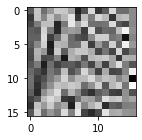

In [327]:
plot_image(U[0])

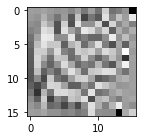

In [328]:
plot_image(U[1])

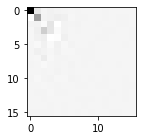

In [329]:
plot_image(S[:,:,0])

In [330]:
A_hosvd = tc.einsum("abc,da,eb,fc->def", tc.as_tensor(S), tc.as_tensor(U[0]), tc.as_tensor(U[1]), tc.as_tensor(U[2]))

In [331]:
hosvd_tensor = tc.Tensor.cpu(A_hosvd).detach().numpy()[:,:,:]

In [332]:
tensor.shape, hosvd_tensor.shape

((16, 16, 658), (16, 16, 658))

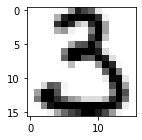

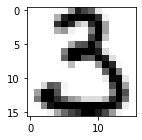

In [333]:
plot_image(tensor[:,:,0])
plot_image(hosvd_tensor[:,:,0])

In [334]:
error = np.linalg.norm(tensor - hosvd_tensor)
error

7.951257058125007e-13

In [335]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [521]:
S_list, U_list = getSandUList(x_Train)

In [337]:
U1, U2, U3 = U_list[3]
S = S_list[3]
S.shape, U1.shape, U2.shape, U3.shape

((16, 16, 658), (16, 16), (16, 16), (658, 658))

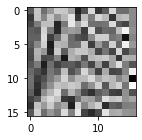

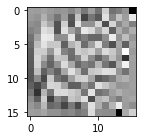

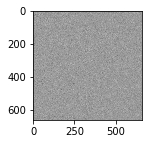

In [338]:
plot_image(U1)
plot_image(U2)
plot_image(U3)

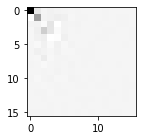

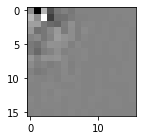

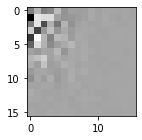

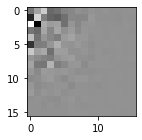

In [339]:
plot_image(S[:,:,0])
plot_image(S[:,:,1])
plot_image(S[:,:,2])
plot_image(S[:,:,3])

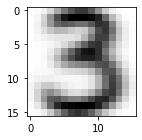

In [340]:
Aj = U1.dot(S[:,:,0]).dot(U2.T)
plot_image(Aj)

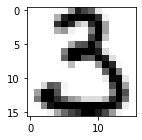

In [341]:
Z = x_Train[4][:].reshape([16, 16])
plot_image(Z)

In [342]:
 Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
 Cj

0.04179627116659144

In [343]:
G = np.linalg.norm(Z-Cj*Aj, 2)
G

2.5013599861892444

In [344]:
U1, U2, U3 = U_list[2]
S = S_list[2]
S.shape, U1.shape, U2.shape, U3.shape

((16, 16, 731), (16, 16), (16, 16), (731, 731))

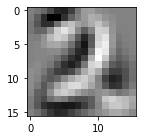

In [345]:
Aj = U1.dot(S[:,:,3]).dot(U2.T)
plot_image(Aj)

In [346]:
 Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
 Cj

0.03371456395196703

In [347]:
G = np.linalg.norm(Z-Cj*Aj, 2)
G

6.0779136949076555

In [348]:
result_Train_list, y_Train_predict, result_Train_predict, result_Train_residual, result_Train_mse = hosvdAlgorithm(x_Train, y_Train, S_list, U_list, 4)

In [349]:
result_Train_predict

0.920175558908243

In [350]:
result_Train_residual[7290]

array([0.02027895, 0.00790079, 0.0174685 , 0.01878735, 0.01523847,
       0.018218  , 0.01498122, 0.017311  , 0.01310196, 0.01200696])

In [351]:
result_Train_mse

[3.587710876422987, 1.986970237278837, 1.4770264709916334, 1.2575778356878342]

Text(0.5, 0, 'number of basis')

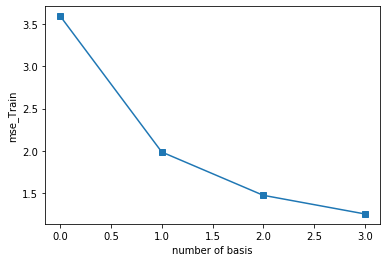

In [352]:
plt.plot(result_Train_mse,'s-')
plt.ylabel('mse_Train')
plt.xlabel('number of basis')

In [353]:
result_Test_list, y_Test_predict, result_Test_predict, result_Test_residual, result_Test_mse = hosvdAlgorithm(x_Test, y_Test, S_list, U_list, 10)

In [354]:
result_Test_predict

0.9157947184853015

In [355]:
result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']]

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,actual,prediction,residual
12,0.000000,0.000000,0.002880,0.002771,0.003922,0.003922,0.002867,0.001733,0.000124,0.000000,...,0.002490,0.001412,0.000284,0.000000,0.000000,0.000000,0.000000,2,3.0,0.010047
13,0.000000,0.000000,0.000127,0.002241,0.003312,0.003922,0.002559,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,8.0,0.009047
17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000222,0.002727,0.000863,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,2.0,0.010205
27,0.000000,0.000000,0.000033,0.003259,0.000963,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002967,0.001978,0.000778,0.000000,0.000000,0.000000,0.000000,3,5.0,0.010392
48,0.001282,0.003745,0.001737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002196,0.001055,0.001276,0.000310,0.000000,0.000000,0.000000,2,6.0,0.013189
52,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000357,0.003055,0.003745,0.000682,...,0.002716,0.003820,0.002614,0.002596,0.000524,0.000000,0.000000,1,2.0,0.011439
62,0.000000,0.000000,0.000000,0.000000,0.001233,0.003922,0.000739,0.001035,0.003684,0.003337,...,0.000439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,9.0,0.009603
67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.0,0.011874
78,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,4.0,0.009266
131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,4.0,0.008286


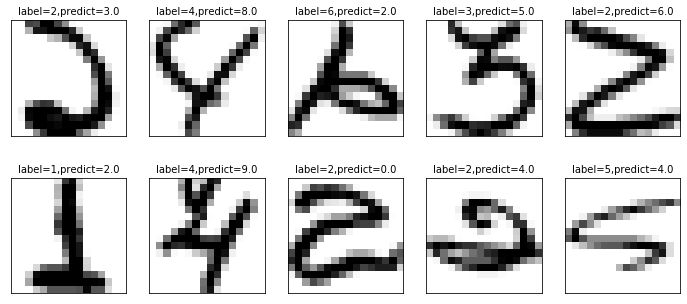

In [356]:
errorList = result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']]

errorList.shape

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [357]:
temp = errorList[['actual', 'prediction']].groupby(['actual', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

,0,1,2,3,4,5,6,7,8,9
0,8.0,6.0,0.0,5.0,9.0,3.0,5.0,9.0,2.0,4.0
1,4.0,4.0,13.0,19.0,7.0,9.0,3.0,7.0,4.0,4.0
2,2.0,4.0,4.0,8.0,6.0,9.0,2.0,4.0,5.0,7.0
3,2.0,2.0,4.0,5.0,4.0,3.0,2.0,4.0,4.0,3.0


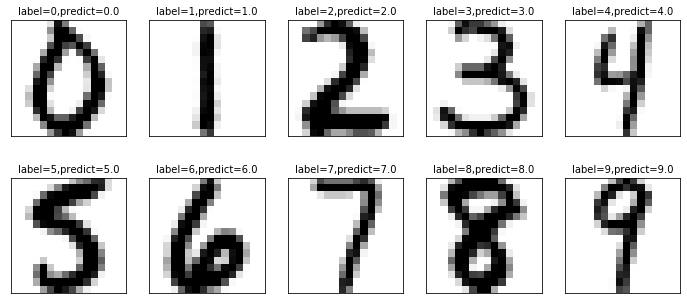

In [358]:
minList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = result_Test_list.iloc[result_Test_list.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

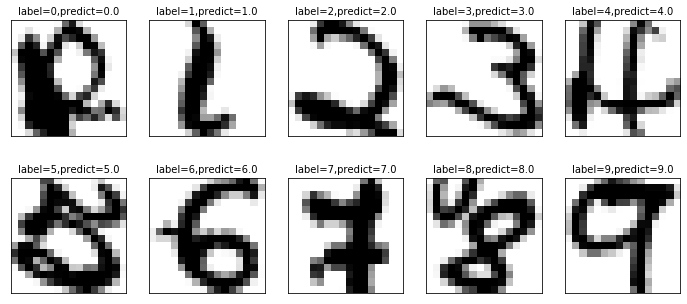

In [359]:
maxList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = result_Test_list.iloc[result_Test_list.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [360]:
result_Test_residual[2006]

array([0.01892433, 0.00148868, 0.01481788, 0.01671563, 0.00819536,
       0.01475702, 0.011525  , 0.01439464, 0.01173524, 0.01012015])

In [361]:
result_Test_mse

[4.646238166417539,
 2.5112107623318387,
 2.1524663677130045,
 1.7404085700049825,
 1.5371200797209765,
 1.4349775784753362,
 1.3996013951170903,
 1.271549576482312,
 1.168410563029397,
 1.2386646736422522]

Text(0.5, 0, 'number of basis')

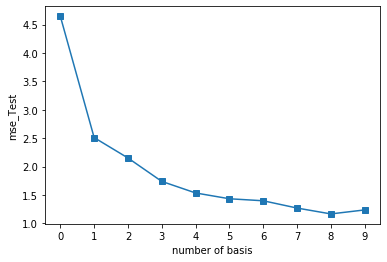

In [362]:
plt.plot(result_Test_mse,'s-')
plt.xticks(range(0,10))
plt.ylabel('mse_Test')
plt.xlabel('number of basis')

In [363]:
components = np.where(y_Test == 2)[0]
components
x_Test_2 = x_Test[components, :]
y_Test_2 = np.full(x_Test_2.shape[0],2)

In [364]:
result_Test_2_list, y_Test_2_predict, result_Test_2_predict, result_Test_2_residual, result_Test_2_mse = hosvdAlgorithm(x_Test_2, y_Test_2, S_list, U_list, 10)

In [365]:
result_Test_2_predict

0.8585858585858586

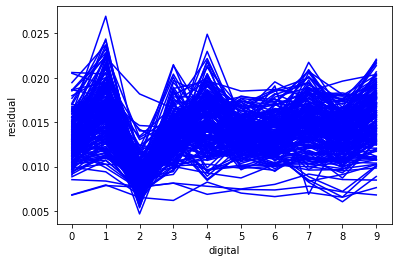

In [366]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_2.shape[0]):
    plt.plot(result_Test_2_residual[i],color = 'blue')

In [367]:
components = np.where(y_Test == 3)[0]
components
x_Test_3 = x_Test[components, :]
y_Test_3 = np.full(x_Test_3.shape[0],3)

In [368]:
result_Test_3_list, y_Test_3_predict, result_Test_3_predict, result_Test_3_residual, result_Test_3_mse = hosvdAlgorithm(x_Test_3, y_Test_3, S_list, U_list, 10)

In [369]:
result_Test_3_predict

0.8132530120481928

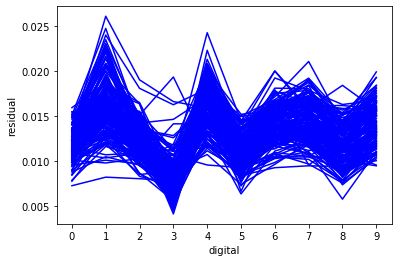

In [370]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_3.shape[0]):
    plt.plot(result_Test_3_residual[i],color = 'blue')

In [371]:
components = np.where(y_Test == 5)[0]
components
x_Test_5 = x_Test[components, :]
y_Test_5 = np.full(x_Test_5.shape[0],5)

In [372]:
result_Test_5_list, y_Test_5_predict, result_Test_5_predict, result_Test_5_residual, result_Test_5_mse = hosvdAlgorithm(x_Test_5, y_Test_5, S_list, U_list, 10)

In [373]:
result_Test_5_predict

0.88125

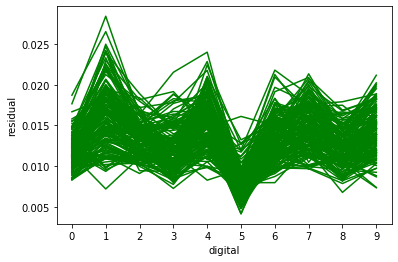

In [374]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_5.shape[0]):
    plt.plot(result_Test_5_residual[i],color = 'green')

In [375]:
components = np.where(y_Test == 7)[0]
components
x_Test_7 = x_Test[components, :]
y_Test_7 = np.full(x_Test_7.shape[0],7)

In [376]:
result_Test_7_list, y_Test_7_predict, result_Test_7_predict, result_Test_7_residual, result_Test_7_mse = hosvdAlgorithm(x_Test_7, y_Test_7, S_list, U_list, 10)

In [377]:
result_Test_7_predict

0.9047619047619048

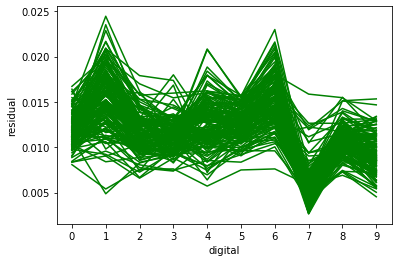

In [378]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_7.shape[0]):
    plt.plot(result_Test_7_residual[i],color = 'green')

In [522]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [523]:
result_Teacher_list, y_Teacher_predict, result_Teacher_predict, result_Teacher_residual, result_Teacher_mse = hosvdAlgorithm(x_Teacher, y_Teacher, S_list, U_list, 10)
result_Teacher_predict

0.4

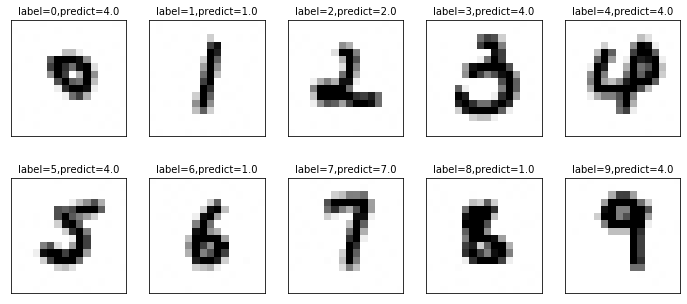

In [524]:
plot_images_labels_prediction(result_Teacher_list.iloc[:,np.arange(0, 256)], result_Teacher_list.iloc[:,[256]], result_Teacher_list.iloc[:,[257]],0,10)

In [525]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [526]:
result_Teacher_list, y_Teacher_predict, result_Teacher_predict, result_Teacher_residual, result_Teacher_mse = hosvdAlgorithm(x_Teacher, y_Teacher, S_list, U_list, 10)
result_Teacher_predict

0.9

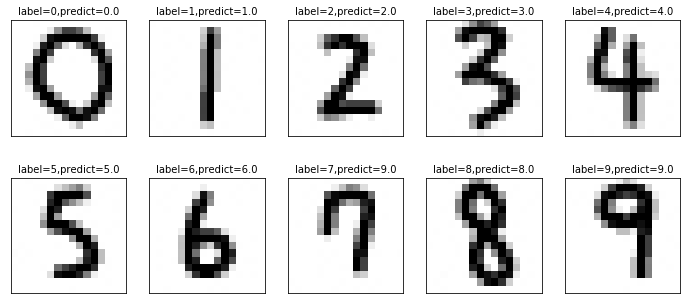

In [527]:
plot_images_labels_prediction(result_Teacher_list.iloc[:,np.arange(0, 256)], result_Teacher_list.iloc[:,[256]], result_Teacher_list.iloc[:,[257]],0,10)

# Classification Using Random Forest (隨機森林演算法)

In [610]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [611]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

In [612]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=10,random_state=3,n_jobs=2)

In [613]:
forest.fit(x_Train,y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [614]:
y_Test_pred = forest.predict(x_Test)

In [615]:
prediction_data = pd.concat([pd.DataFrame(y_Test, columns=['actual']), pd.DataFrame(y_Test_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.916791230692576

In [616]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [617]:
y_Teacher_pred = forest.predict(x_Teacher)

In [618]:
prediction_data = pd.concat([pd.DataFrame(y_Teacher, columns=['actual']), pd.DataFrame(y_Teacher_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.2

In [619]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [620]:
y_Teacher_pred = forest.predict(x_Teacher)

In [621]:
prediction_data = pd.concat([pd.DataFrame(y_Teacher, columns=['actual']), pd.DataFrame(y_Teacher_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.7

# Classification Using MLP (多層感知器)

In [622]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

In [623]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [624]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [625]:
model = Sequential()
                
model.add(Dense(input_dim=256,
                units=256,
                kernel_initializer='normal',
                activation='relu'))

model.add(Dense(units=256,
                kernel_initializer='normal',
                activation='relu'))

model.add(Dense(units=10,
                kernel_initializer='normal',
                activation='softmax'))

In [626]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 0s - loss: 1.4611 - accuracy: 0.6127 - val_loss: 0.6053 - val_accuracy: 0.8657
Epoch 2/20
20/20 - 0s - loss: 0.3886 - accuracy: 0.8978 - val_loss: 0.2849 - val_accuracy: 0.9109
Epoch 3/20
20/20 - 0s - loss: 0.2362 - accuracy: 0.9355 - val_loss: 0.2375 - val_accuracy: 0.9260
Epoch 4/20
20/20 - 0s - loss: 0.1893 - accuracy: 0.9482 - val_loss: 0.1832 - val_accuracy: 0.9465
Epoch 5/20
20/20 - 0s - loss: 0.1580 - accuracy: 0.9592 - val_loss: 0.1766 - val_accuracy: 0.9493
Epoch 6/20
20/20 - 0s - loss: 0.1347 - accuracy: 0.9633 - val_loss: 0.1730 - val_accuracy: 0.9507
Epoch 7/20
20/20 - 0s - loss: 0.1253 - accuracy: 0.9662 - val_loss: 0.1536 - val_accuracy: 0.9561
Epoch 8/20
20/20 - 0s - loss: 0.1059 - accuracy: 0.9729 - val_loss: 0.1434 - val_accuracy: 0.9589
Epoch 9/20
20/20 - 0s - loss: 0.0961 - accuracy: 0.9743 - val_loss: 0.1482 - val_accuracy: 0.9561
Epoch 10/20
20/20 - 0s - loss: 0.0816 - accuracy: 0.9777 - val_loss: 0.1262 - val_accuracy: 0.9630
Epoch 11/20
20/20 -

In [627]:
scores = model.evaluate(x_Test , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 1ms/step - loss: 0.3268 - accuracy: 0.9337


0.9337319135665894

In [628]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [629]:
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [630]:
scores = model.evaluate(x_Teacher , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 8ms/step - loss: 1533.7300 - accuracy: 0.2000


0.20000000298023224

In [631]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [632]:
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [633]:
scores = model.evaluate(x_Teacher , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000


1.0

# Classification Using CNN (卷積神經網路)

In [634]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.utils import np_utils

In [635]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [636]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [637]:
# 多加一個顏色的維度 
x_Train4D=x_Train_tensor.reshape(x_Train_tensor.shape[0],16,16,1).astype('float32')
x_Test4D=x_Test_tensor.reshape(x_Test_tensor.shape[0],16,16,1).astype('float32')

In [638]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [639]:
# define network structure

model = Sequential()

# initializing CNN

# 一個 Convolution Operation 搭配 一個 Pooling

# 二維卷積層 : filter為16, Kernel size為(5,5),Padding為(same)
model.add(Conv2D(filters=16,
                 kernel_size=(5,5),
                 padding='same',
                 input_shape=(16,16,1), 
                 activation='relu'))

# MaxPooling size為(2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer

model.add(Conv2D(filters=36,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Drop掉部分神經元避免overfitting
model.add(Dropout(0.25))

# 平坦化
model.add(Flatten())

# Fully Connected Networks

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='softmax'))

In [640]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train4D, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 2s - loss: 1.6902 - accuracy: 0.4450 - val_loss: 0.7547 - val_accuracy: 0.7971
Epoch 2/20
20/20 - 2s - loss: 0.6194 - accuracy: 0.8011 - val_loss: 0.2863 - val_accuracy: 0.9123
Epoch 3/20
20/20 - 2s - loss: 0.3538 - accuracy: 0.8920 - val_loss: 0.2152 - val_accuracy: 0.9301
Epoch 4/20
20/20 - 2s - loss: 0.2685 - accuracy: 0.9201 - val_loss: 0.1625 - val_accuracy: 0.9527
Epoch 5/20
20/20 - 3s - loss: 0.2202 - accuracy: 0.9326 - val_loss: 0.1346 - val_accuracy: 0.9520
Epoch 6/20
20/20 - 2s - loss: 0.1823 - accuracy: 0.9499 - val_loss: 0.1150 - val_accuracy: 0.9589
Epoch 7/20
20/20 - 2s - loss: 0.1579 - accuracy: 0.9544 - val_loss: 0.0961 - val_accuracy: 0.9657
Epoch 8/20
20/20 - 2s - loss: 0.1380 - accuracy: 0.9606 - val_loss: 0.0879 - val_accuracy: 0.9685
Epoch 9/20
20/20 - 2s - loss: 0.1223 - accuracy: 0.9638 - val_loss: 0.0831 - val_accuracy: 0.9719
Epoch 10/20
20/20 - 3s - loss: 0.0975 - accuracy: 0.9710 - val_loss: 0.0716 - val_accuracy: 0.9719
Epoch 11/20
20/20 -

In [641]:
scores = model.evaluate(x_Test4D , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 6ms/step - loss: 0.1611 - accuracy: 0.9576


0.9576482176780701

In [642]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [643]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
x_Teacher4D=x_Teacher_tensor.reshape(x_Teacher_tensor.shape[0],16,16,1).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [644]:
scores = model.evaluate(x_Teacher4D , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 7ms/step - loss: 675.8195 - accuracy: 0.5000


0.5

In [645]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [646]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
x_Teacher4D=x_Teacher_tensor.reshape(x_Teacher_tensor.shape[0],16,16,1).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [647]:
scores = model.evaluate(x_Teacher4D , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000


1.0

# Classification Using RNN (循環神經網路)

In [648]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN
from keras.utils import np_utils

In [649]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [650]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [651]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [652]:
# define network structure

model = Sequential()

model.add(SimpleRNN(input_shape=(16,16),
                    units = 256,
                    unroll=True))

model.add(Dropout(0.1))

model.add(Dense(units=10,kernel_initializer='normal',activation='softmax'))

In [653]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train_tensor, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 1s - loss: 1.1771 - accuracy: 0.6663 - val_loss: 0.5546 - val_accuracy: 0.8568
Epoch 2/20
20/20 - 1s - loss: 0.4321 - accuracy: 0.8865 - val_loss: 0.3138 - val_accuracy: 0.9184
Epoch 3/20
20/20 - 1s - loss: 0.2856 - accuracy: 0.9206 - val_loss: 0.2343 - val_accuracy: 0.9397
Epoch 4/20
20/20 - 1s - loss: 0.2178 - accuracy: 0.9395 - val_loss: 0.2149 - val_accuracy: 0.9397
Epoch 5/20
20/20 - 1s - loss: 0.1839 - accuracy: 0.9474 - val_loss: 0.1959 - val_accuracy: 0.9445
Epoch 6/20
20/20 - 1s - loss: 0.1666 - accuracy: 0.9539 - val_loss: 0.1520 - val_accuracy: 0.9575
Epoch 7/20
20/20 - 1s - loss: 0.1389 - accuracy: 0.9612 - val_loss: 0.1413 - val_accuracy: 0.9589
Epoch 8/20
20/20 - 1s - loss: 0.1138 - accuracy: 0.9698 - val_loss: 0.1301 - val_accuracy: 0.9623
Epoch 9/20
20/20 - 1s - loss: 0.1003 - accuracy: 0.9727 - val_loss: 0.1223 - val_accuracy: 0.9657
Epoch 10/20
20/20 - 1s - loss: 0.0865 - accuracy: 0.9767 - val_loss: 0.1182 - val_accuracy: 0.9692
Epoch 11/20
20/20 -

In [654]:
scores = model.evaluate(x_Test_tensor , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 5ms/step - loss: 0.2662 - accuracy: 0.9337


0.9337319135665894

In [655]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [656]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [657]:
scores = model.evaluate(x_Teacher_tensor , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 10ms/step - loss: 3.9261 - accuracy: 0.3000


0.30000001192092896

In [658]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [659]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [660]:
scores = model.evaluate(x_Teacher_tensor , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 5ms/step - loss: 3.9237 - accuracy: 0.2000


0.20000000298023224

# Classification Using LSTM (長短期記憶循環神經網路)

In [661]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM

In [662]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [663]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [664]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [665]:
model = Sequential()

model.add(LSTM(input_shape=(16, 16),
                units=256,
                unroll=False))

model.add(Dropout(0.1))

model.add(Dense(units=10,kernel_initializer='normal',activation='softmax'))

In [666]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train_tensor, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 7s - loss: 1.8653 - accuracy: 0.3515 - val_loss: 1.4062 - val_accuracy: 0.5086
Epoch 2/20
20/20 - 6s - loss: 1.0996 - accuracy: 0.6403 - val_loss: 0.8282 - val_accuracy: 0.7197
Epoch 3/20
20/20 - 6s - loss: 0.6677 - accuracy: 0.7725 - val_loss: 0.5708 - val_accuracy: 0.8074
Epoch 4/20
20/20 - 6s - loss: 0.4551 - accuracy: 0.8508 - val_loss: 0.4340 - val_accuracy: 0.8506
Epoch 5/20
20/20 - 5s - loss: 0.3398 - accuracy: 0.8981 - val_loss: 0.3097 - val_accuracy: 0.9013
Epoch 6/20
20/20 - 5s - loss: 0.2511 - accuracy: 0.9246 - val_loss: 0.2462 - val_accuracy: 0.9191
Epoch 7/20
20/20 - 6s - loss: 0.2221 - accuracy: 0.9319 - val_loss: 0.2179 - val_accuracy: 0.9246
Epoch 8/20
20/20 - 5s - loss: 0.1992 - accuracy: 0.9390 - val_loss: 0.1923 - val_accuracy: 0.9301
Epoch 9/20
20/20 - 5s - loss: 0.1521 - accuracy: 0.9549 - val_loss: 0.1715 - val_accuracy: 0.9397
Epoch 10/20
20/20 - 5s - loss: 0.1393 - accuracy: 0.9559 - val_loss: 0.1560 - val_accuracy: 0.9459
Epoch 11/20
20/20 -

In [667]:
scores = model.evaluate(x_Test_tensor , y_TestOneHot)
scores[1]

63/63 [==============================] - 2s 25ms/step - loss: 0.2536 - accuracy: 0.9377


0.9377179741859436

In [668]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [669]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [670]:
scores = model.evaluate(x_Teacher_tensor , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 6ms/step - loss: 3.4101 - accuracy: 0.1000


0.10000000149011612

In [671]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [672]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [673]:
scores = model.evaluate(x_Teacher_tensor , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 5ms/step - loss: 2.8256 - accuracy: 0.2000


0.20000000298023224